In [6]:
# ============================================================
# EBM CREDIT SCORING - FULL THESIS PIPELINE
# ============================================================
# Tác giả: Gemini & User
# Mục tiêu: So sánh EBM Baseline vs. EBM Optimized (Optuna)
# ============================================================

import pandas as pd
import numpy as np
import optuna
import pickle
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import roc_auc_score
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.model_selection import StratifiedKFold

# Cấu hình hiển thị pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# ============================================================
# 1. HÀM TIỆN ÍCH (UTILS)
# ============================================================

def feature_engineering_advanced(df_in):
    """
    Tạo biến phái sinh và xử lý số liệu (Bước BẮT BUỘC để tăng Gini)
    """
    df = df_in.copy()
    print("   -> Đang tạo biến phái sinh (Feature Engineering)...")
    
    # 1.1. Tạo các biến tỷ lệ tài chính (Ratios)
    # DTI: Debt to Income (Dư nợ / Thu nhập)
    df['INCOME'] = df['INCOME'].fillna(0)
    df['CBAL'] = df['CBAL'].fillna(0)

    df['RATIO_DTI'] = df['CBAL'] / (df['INCOME'] + 1)
    
    # Utilization: Dư nợ / Hạn mức (Mức độ "đói" vốn)
    # Tránh chia cho 0 bằng cách replace 0 thành 1
    df['RATIO_UTILIZATION'] = df['CBAL'] / (df['AFLIMT_MAX'].replace(0, 1))
    
    # Payment Burden ước tính (Giả sử trả 3% dư nợ mỗi tháng)
    df['RATIO_PAYMENT_TO_INCOME'] = (df['CBAL'] * 0.03) / (df['INCOME'] + 1)
    
    # 1.2. Cắt đuôi ngoại lai (Winsorization/Clipping)
    # Giúp biểu đồ EBM không bị kéo dãn bởi vài khách hàng siêu giàu
    vars_to_clip = ['INCOME', 'CBAL', 'BASE_AUM', 'RATIO_DTI']
    for col in vars_to_clip:
        if col in df.columns:
            lower = df[col].quantile(0.005)
            upper = df[col].quantile(0.995)
            df[col] = df[col].clip(lower, upper)

            
    # 1.3. Missing Value Flag (Nếu có)
    # Ví dụ: Nếu không có thông tin tiền gửi -> Rủi ro cao
    if 'N_AVG_DEPOSIT_12M' in df.columns:
        df['FLAG_MISSING_DEPOSIT'] = np.where(df['N_AVG_DEPOSIT_12M'].isna() | (df['N_AVG_DEPOSIT_12M'] == 0), 1, 0)
        
    return df

def calculate_gini(model, X, y, label=""):
    """Tính Gini và in ra màn hình"""
    prob = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, prob)
    gini = 2 * auc - 1
    if label:
        print(f"   [{label}] AUC: {auc:.4f} | GINI: {gini:.4f}")
    return gini

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    """
    Tính chỉ số ổn định PSI (Population Stability Index) giữa Train và Test
    PSI < 0.1: Ổn định | 0.1 - 0.25: Biến động nhẹ | > 0.25: Biến động mạnh
    """
    def psi(expected_array, actual_array, buckets):
        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
        
        if buckettype == 'bins':
            breakpoints = np.percentile(expected_array, breakpoints)
        
        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
        
        def sub_psi(e_perc, a_perc):
            if a_perc == 0: a_perc = 0.0001
            if e_perc == 0: e_perc = 0.0001
            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum([sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents))])
        return psi_value

    return psi(expected, actual, buckets)

# ============================================================
# 2. MAIN WORKFLOW
# ============================================================

print(">>> [1/6] LOADING & PRE-PROCESSING DATA...")
# Đọc dữ liệu
try:
    df = pd.read_parquet(r'C:\Users\PC\Documents\GitHub\Khoa-luan\gen_data.parquet')
except FileNotFoundError:
    print("LỖI: Không tìm thấy file 'credit_dataset.csv'. Hãy chạy file Gen Data trước.")
    exit()

from sklearn.preprocessing import LabelEncoder

# Áp dụng Feature Engineering (Bước mới thêm vào)
df = feature_engineering_advanced(df)

# Định nghĩa cột
target_col = 'BAD_NEXT_12M'
excluded_cols = [ 
    # 1. Các biến định danh & Thời gian (Không dùng dự báo)
    'SOCIF', 'CASE_ID', 'SAMPLE_TYPE', 'year', 
    'SNAPSHOT_DATE', 'REF_MONTH', 'REF_DAY', 
    
    # 2. Target & Các biến quản lý rủi ro hiện tại
    'BAD_NEXT_12M',    # Biến mục tiêu
    'BAD_CURRENT',     # Đã dùng để lọc quần thể, không đưa vào model
    'XULYNO', 
    'MAX_NHOMNOCIC', 
    'INHERENT_RISK', 
    'CURRENT_RISK',

    # 3. CÁC BIẾN LEAKAGE (QUAN TRỌNG: Phải loại bỏ hết)
    # Lý do: Các biến này thường được tính trong khoảng thời gian 12 tháng tới (Performance Window)
    'MAX_DPD_12M',              # Max ngày quá hạn 12 tháng tới
    'AVG_OD_DPD_12M',           # Trung bình ngày quá hạn 12 tháng tới
    'SUM_ALL_OD_12M',           # Tổng tiền quá hạn 12 tháng tới
    'N_AVG_OVERDUE_CBAL_12M'    # Trung bình dư nợ quá hạn 12 tháng tới
]


df['INCOME_LOG'] = np.log1p(df['INCOME'])
df['CBAL_LOG'] = np.log1p(df['CBAL'])
df['AUM_LOG'] = np.log1p(df['BASE_AUM'])



df['RATIO_DTI'] = df['RATIO_DTI'].clip(0, 10)
df['RATIO_UTILIZATION'] = df['RATIO_UTILIZATION'].clip(0, 5)

df['DTI_x_LTV'] = df['RATIO_DTI'] * df['LTV']
df['DEPOSIT_x_INCOME'] = df['N_AVG_DEPOSIT_12M'] * df['INCOME_LOG']

df = df[df['BAD_CURRENT'] == 0].copy()
feature_cols = [c for c in df.columns if c not in excluded_cols]
len(feature_cols)
# Chia tập dữ liệu (Train / OOS / OOT)
X_train = df[df['SAMPLE_TYPE'] == 'TRAIN'][feature_cols]
y_train = df[df['SAMPLE_TYPE'] == 'TRAIN'][target_col]

X_val   = df[df['SAMPLE_TYPE'] == 'OOS'][feature_cols]   # Validation (2022)
y_val   = df[df['SAMPLE_TYPE'] == 'OOS'][target_col]

X_test  = df[df['SAMPLE_TYPE'] == 'OOT'][feature_cols]   # Test (2023)
y_test  = df[df['SAMPLE_TYPE'] == 'OOT'][target_col]

print(f"   Train: {X_train.shape} | OOS: {X_val.shape} | OOT: {X_test.shape}")

# ------------------------------------------------------------
# CẤU HÌNH MONOTONICITY (RÀNG BUỘC ĐƠN ĐIỆU)
# ------------------------------------------------------------
# 1: Tăng (Giá trị biến tăng -> Risk tăng)
# -1: Giảm (Giá trị biến tăng -> Risk giảm)
# 0: Không ép buộc
mono_constraints_dict = {
    'MAX_DPD_12M_OBS': 1, 'MAX_NHOMNOCIC': 1, 'AVG_OD_DPD_12M': 1, 
    'SUM_ALL_OD_12M': 1, 'N_AVG_OVERDUE_CBAL_12M': 1,
    'CBAL': 1, 'CBAL_AVG': 1, 'CBAL_MAX': 1, 'CBALORG': 1,
    'CBAL_SHORTTERM_LOAN': 1, 'CBAL_LONGTERM_LOAN': 1, 'AFLIMT_AVG': 1, 'AFLIMT_MIN': 1,
    'LTV': 1, 'CBAL_TO_INC_12MON': 1, 'RATE_AVG': 1,
    'RATIO_DTI': 1, 'RATIO_UTILIZATION': 1,    

    'INCOME': -1, 'BASE_AUM': -1, 'INCOME_LOG': -1, 'AUM_LOG': -1,
    'N_AVG_DEPOSIT_12M': -1, 'N_AVG_DEPOSIT_6M': -1, 
    'N_AVG_DD_12M': -1, 'N_AVG_CD_12M': -1,
    'SOHUUNHA': -1, 'FLAG_SALARY_ACC': -1, 
    'FLAG_DEPOSIT': -1,

    'TUOI': 0, 'C_GIOITINH': 0, 'TTHONNHAN': 0, 'NHANVIENBIDV': 0,
    'PURCOD_MAX': 0, 'DURATION_MAX': 0, 'REMAINING_DURATION_MAX': 0,
    'REF_MONTH': 0, 'REF_DAY': 0, 'AFLIMT_MAX': 0, 'TRINHDO': 0, 'REAL_GDP_GROWTH_12M': 0, 
    'TIME_TO_OP_MAX': 0
}
# Lưu ý: EBM sẽ bỏ qua constraint nếu tên biến không tồn tại trong data, nên cứ khai báo thoải mái.

mono_constraints_list = [mono_constraints_dict.get(col, 0) for col in feature_cols]

# ===========================================================
# 3. BASELINE MODEL (CHẠY THỬ MẶC ĐỊNH)
# ============================================================
print("\n>>> [2/6] TRAINING BASELINE MODEL...")

ebm_base = ExplainableBoostingClassifier(
    monotone_constraints=mono_constraints_list, 
    interactions=0,               # Mặc định tìm 10 tương tác
    learning_rate=1,
    random_state=42, 
    n_jobs=-1,
    early_stopping_rounds=5
)

ebm_base.fit(X_train, y_train)

# Đánh giá Baseline
print("   Kết quả Baseline:")
gini_base_oos = calculate_gini(ebm_base, X_val, y_val, "OOS-Base")
gini_base_oot = calculate_gini(ebm_base, X_test, y_test, "OOT-Base")

>>> [1/6] LOADING & PRE-PROCESSING DATA...
   -> Đang tạo biến phái sinh (Feature Engineering)...
   Train: (1292291, 61) | OOS: (340904, 61) | OOT: (342652, 61)

>>> [2/6] TRAINING BASELINE MODEL...


c:\Users\PC\miniconda3\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:871: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


   Kết quả Baseline:
   [OOS-Base] AUC: 0.8750 | GINI: 0.7501
   [OOT-Base] AUC: 0.8731 | GINI: 0.7462


In [ ]:
# # ============================================================
# # 4. OPTUNA TUNING – EBM OPTIMIZED
# # ============================================================
# from optuna.pruners import HyperbandPruner
# print("\n>>> [3/6] OPTIMIZING MODEL WITH OPTUNA...")

# def objective(trial):
#     params = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
#         "interactions": trial.suggest_int("interactions", 0, 20),
#         "max_bins": trial.suggest_int("max_bins", 128, 512),
#         "outer_bags": trial.suggest_int("outer_bags", 4, 20),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 100),
#     }

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     gini_scores = []

#     for train_idx, val_idx in skf.split(X_train, y_train):
#         X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         model = ExplainableBoostingClassifier(
#             monotone_constraints=mono_constraints_list,
#             random_state=42,
#             n_jobs=-1,
#             **params
#         )

#         model.fit(X_tr, y_tr)

#         prob = model.predict_proba(X_va)[:, 1]
#         auc = roc_auc_score(y_va, prob)
#         gini_scores.append(2*auc - 1)

#     return np.mean(gini_scores)

# study = optuna.create_study(direction="maximize",
#     pruner=optuna.pruners.MedianPruner(
#         n_startup_trials=5,
#         n_warmup_steps=1,
#         interval_steps=1

#     ))
# study.optimize(objective, n_trials=50)

# print("\n>>> BEST PARAMETERS FOUND:")
# print(study.best_params)
# print(f"Best Gini (OOS): {study.best_value:.4f}")

# # Train lại model optimized
# ebm_opt = ExplainableBoostingClassifier(
#     monotone_constraints=mono_constraints_list,
#     random_state=42,
#     n_jobs=-1,
#     **study.best_params
# )
# ebm_opt.fit(X_train, y_train)

# print("\n>>> [4/6] GINI – EBM OPTIMIZED")
# gini_opt_oos = calculate_gini(ebm_opt, X_val, y_val, "OOS-Optimized")
# gini_opt_oot = calculate_gini(ebm_opt, X_test, y_test, "OOT-Optimized")

# # Visualization
# fig1 = plot_optimization_history(study)
# fig2 = plot_param_importances(study)
# fig1.show()
# fig2.show()

# # Save model
# pickle.dump(ebm_opt, open("ebm_optimized.pkl", "wb"))

In [ ]:
# import optuna.visualization as vis

# # 1. Vẽ Slice Plot cho tất cả các tham số
# fig_slice = vis.plot_slice(study)
# fig_slice.show()

# # 2. Hoặc vẽ Slice Plot cho một vài tham số quan trọng bạn muốn đưa vào bài viết
# fig_specific = vis.plot_slice(study, params=["learning_rate", "min_samples_leaf", "interactions"])
# fig_specific.show()

In [3]:
# Train lại model optimized
ebm_opt = ExplainableBoostingClassifier(
    monotone_constraints=mono_constraints_list,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.041459457759190334, 
    interactions=8, 
    max_bins=325, 
    outer_bags=11, 
    min_samples_leaf=27
)
ebm_opt.fit(X_train, y_train)

print("\n>>> [4/6] GINI – EBM OPTIMIZED")
gini_opt_oos = calculate_gini(ebm_opt, X_val, y_val, "OOS-Optimized")
gini_opt_oot = calculate_gini(ebm_opt, X_test, y_test, "OOT-Optimized")


c:\Users\PC\miniconda3\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:871: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


KeyboardInterrupt: 

In [ ]:
# pickle.dump(ebm_opt, open("ebm_optimized.pkl", "wb"))

In [ ]:
# ============================================================
# 5. MODEL EXPLAINABILITY
# ============================================================

print("\n>>> [5/6] EXPLAINABILITY REPORT...")

# 5.1. GLOBAL FEATURE IMPORTANCE
global_importance = ebm_opt.explain_global()

print("\n>>> TOP FEATURES (Global Importance):")
for i, (name, score) in enumerate(zip(
        global_importance.data()['names'],
        global_importance.data()['scores'])):
    print(f"{i+1:2d}. {name}: {score:.4f}")

# 5.2. HIỂN THỊ BẰNG TRÌNH DUYỆT (nếu chạy trong notebook thì hiện ngay)
try:
    show(global_importance)
except:
    print("   (Không thể render giao diện trực tiếp — vẫn tiếp tục.)")

# 5.3. LOCAL EXPLANATION (giải thích 1 khách hàng bất kỳ)
sample_index = 0 
sample_X = X_test.iloc[[0]]  # vẫn là DataFrame 1 hàng
sample_y = y_test.iloc[0]    # Series scalar, 1D

local_exp = ebm_opt.explain_local(X_test, y_test)
  # Series



print("\n>>> LOCAL EXPLANATION SAMPLE:")
show(local_exp)
print(local_exp.data(0))


try:
    importances = ebm_opt.term_importances()
except:
    try:
        importances = ebm_opt.feature_importances_
    except:
        raise ValueError("Không tìm thấy thuộc tính term_importances hoặc feature_importances.")

terms = ebm_opt.term_names_

print("\n>>> TOP INTERACTIONS:")
for name, imp in sorted(zip(terms, importances), key=lambda x: x[1], reverse=True):
    if "&" in name:  # interaction luôn có ký tự &
        print(f"{name}: {imp:.4f}")


# Lưu phần explain vào file
pickle.dump(global_importance, open("ebm_global_exp.pkl", "wb"))
pickle.dump(local_exp, open("ebm_local_exp.pkl", "wb"))


>>> [5/6] EXPLAINABILITY REPORT...

>>> TOP FEATURES (Global Importance):
 1. C_GIOITINH: 0.0037
 2. TRINHDO: 0.0038
 3. TTHONNHAN: 0.0086
 4. SOHUUNHA: 1.1641
 5. NHANVIENBIDV: 0.0000
 6. BASE_AUM: 0.0421
 7. TUOI: 0.0099
 8. INCOME: 0.0132
 9. CBAL: 0.0074
10. CBALORG: 0.0086
11. AFLIMT_MAX: 0.0036
12. AFLIMT_MIN: 0.0094
13. AFLIMT_AVG: 0.0093
14. CBAL_AVG: 0.0082
15. CBAL_MAX: 0.0091
16. CBAL_MIN: 0.0223
17. COLLATERAL_VALUE: 0.1292
18. LTV: 0.7618
19. N_AVG_DEPOSIT_12M: 0.0944
20. N_AVG_DEPOSIT_6M: 0.0951
21. N_AVG_DD_12M: 0.0974
22. N_AVG_CD_12M: 0.1043
23. FLAG_SALARY_ACC: 0.0098
24. FLAG_DEPOSIT: 0.0655
25. CBAL_SHORTTERM_LOAN: 0.0065
26. CBAL_LONGTERM_LOAN: 0.0059
27. HAS_SHORTTERM_LOAN: 0.0000
28. HAS_LONGTERM_LOAN: 0.0000
29. DURATION_MAX: 0.0022
30. REMAINING_DURATION_MAX: 0.0043
31. TIME_TO_OP_MAX: 0.0039
32. RATE_AVG: 0.0583
33. PURCOD_MAX: 0.0006
34. PURCOD_MIN: 0.0006
35. MAX_DPD_12M: 0.6290
36. MAX_DPD_12M_OBS: 0.6089
37. AVG_OD_DPD_12M: 0.2149
38. SUM_ALL_OD_12M: 0.30

<!-- http://127.0.0.1:7001/2624862632016/ -->


>>> LOCAL EXPLANATION SAMPLE:


<!-- http://127.0.0.1:7001/2624771550544/ -->

{'type': 'univariate', 'names': ['C_GIOITINH', 'TRINHDO', 'TTHONNHAN', 'SOHUUNHA', 'NHANVIENBIDV', 'BASE_AUM', 'TUOI', 'INCOME', 'CBAL', 'CBALORG', 'AFLIMT_MAX', 'AFLIMT_MIN', 'AFLIMT_AVG', 'CBAL_AVG', 'CBAL_MAX', 'CBAL_MIN', 'COLLATERAL_VALUE', 'LTV', 'N_AVG_DEPOSIT_12M', 'N_AVG_DEPOSIT_6M', 'N_AVG_DD_12M', 'N_AVG_CD_12M', 'FLAG_SALARY_ACC', 'FLAG_DEPOSIT', 'CBAL_SHORTTERM_LOAN', 'CBAL_LONGTERM_LOAN', 'HAS_SHORTTERM_LOAN', 'HAS_LONGTERM_LOAN', 'DURATION_MAX', 'REMAINING_DURATION_MAX', 'TIME_TO_OP_MAX', 'RATE_AVG', 'PURCOD_MAX', 'PURCOD_MIN', 'MAX_DPD_12M', 'MAX_DPD_12M_OBS', 'AVG_OD_DPD_12M', 'SUM_ALL_OD_12M', 'N_AVG_OVERDUE_CBAL_12M', 'CBAL_TO_INC_12MON', 'REAL_GDP_GROWTH_12M', 'RATIO_DTI', 'RATIO_UTILIZATION', 'RATIO_PAYMENT_TO_INCOME', 'FLAG_MISSING_DEPOSIT', 'INCOME_LOG', 'CBAL_LOG', 'AUM_LOG', 'C_GIOITINH & AFLIMT_MAX', 'TRINHDO & COLLATERAL_VALUE', 'TUOI & COLLATERAL_VALUE', 'AFLIMT_MAX & COLLATERAL_VALUE', 'CBAL_MIN & COLLATERAL_VALUE', 'COLLATERAL_VALUE & REAL_GDP_GROWTH_12M',

Global importance: 
- Giá trị tuyệt đối trung bình của điểm số (Average Absolute Score) mà biến đó đóng góp vào dự báo trên toàn bộ tập dữ liệu: Trung bình, biến này làm thay đổi dự đoán (log-odds) bao nhiêu đơn vị? Số càng lớn = Biến càng quan trọng.

Cách tính, ví dụ với biến SOHUUNHA:
- Bước 1: Tính Score cho từng người: Với mỗi khách hàng trong tập dữ liệu, mô hình xem khách hàng đó có nhà hay không (SOHUUNHA = 1 hoặc 0). Sau đó, nó tra cứu trong bảng hàm hình dạng xem giá trị đó tương ứng với bao nhiêu điểm (ví dụ: Có nhà thì $-0.8$ điểm, không nhà thì $+1.3$ điểm rủi ro).

- Bước 2: Lấy trị tuyệt đối: Vì mô hình muốn đo lường mức độ tác động (dù là làm tăng hay giảm rủi ro đều được coi là quan trọng), nên nó lấy trị tuyệt đối của tất cả các điểm số đó: $|-0.8| = 0.8$ và $|1.3| = 1.3$.

- Bước 3: Tính trung bình: Cộng tất cả các trị tuyệt đối này lại và chia cho tổng số khách hàng. Kết quả cuối cùng chính là con số bạn thấy.

Tác động của biến SOHUUNHA: 
- SOHUUNHA ≈ 0 (Không sở hữu nhà): * Giá trị Score nằm ở mức khoảng +0.8. Những khách hàng không có nhà riêng có xu hướng làm tăng xác suất của biến mục tiêu
- SOHUUNHA ≈ 1 (Có sở hữu nhà): * Giá trị Score giảm mạnh xuống mức khoảng -1.5. Việc sở hữu nhà đóng góp một giá trị âm rất lớn vào tổng điểm. Điều này làm giảm mạnh xác suất xảy ra biến mục tiêu

In [ ]:
# ============================================================
# 6. FINAL REPORT – PSI, COMPARISON, SUMMARY
# ============================================================

print("\n>>> [6/6] FINAL MODEL REPORT...")

# 6.1. Tính PSI của 2 biến chính giữa Train – OOT
psi_report = {}
for col in ["INCOME", "CBAL", "RATIO_DTI", "RATIO_UTILIZATION"]:
    try:
        psi_report[col] = calculate_psi(
            X_train[col].values,
            X_test[col].values
        )
    except:
        psi_report[col] = None

print("\n>>> PSI REPORT (Train → OOT):")
for k,v in psi_report.items():
    print(f"   {k}: {v:.4f}")

# 6.2. So sánh Gini Baseline vs Optimized
print("\n>>> GINI COMPARISON")
print(f"Baseline – OOS: {gini_base_oos:.4f}")
print(f"Optimized – OOS: {gini_opt_oos:.4f}")
print(f"Baseline – OOT: {gini_base_oot:.4f}")
print(f"Optimized – OOT: {gini_opt_oot:.4f}")

# 6.3. Lưu bản summary ra file TXT
# Best Hyperparameters:
# {study.best_params}
# """
summary_text = f"""
=============================
EBM CREDIT SCORING SUMMARY
=============================

GINI – OOS:
 - Baseline:  {gini_base_oos:.4f}
 - Optimized: {gini_opt_oos:.4f}

GINI – OOT:
 - Baseline:  {gini_base_oot:.4f}
 - Optimized: {gini_opt_oot:.4f}

PSI (Train → OOT):
{psi_report}

"""

with open("model_summary.txt", "w") as f:
    f.write(summary_text)

print("\n>>> SUMMARY EXPORTED → model_summary.txt\n")



>>> [6/6] FINAL MODEL REPORT...

>>> PSI REPORT (Train → OOT):
   INCOME: 0.0003
   CBAL: 0.0022
   RATIO_DTI: 0.0031
   RATIO_UTILIZATION: 0.0035

>>> GINI COMPARISON
Baseline – OOS: 0.8812
Optimized – OOS: 0.8804
Baseline – OOT: 0.8824
Optimized – OOT: 0.8815

>>> SUMMARY EXPORTED → model_summary.txt



Mô hình rất ổn định khi chuyển từ TRAIN → OOT

In [ ]:
# 6.4. Tính PSI cho Score (Xác suất dự báo) - QUAN TRỌNG NHẤT
prob_train = ebm_opt.predict_proba(X_train)[:, 1]
prob_oot = ebm_opt.predict_proba(X_test)[:, 1]

psi_score = calculate_psi(prob_train, prob_oot)
print(f"\n>>> FINAL MODEL STABILITY (PSI Score): {psi_score:.4f}")
if psi_score < 0.1:
    print("    => Kết luận: Mô hình cực kỳ ổn định qua thời gian.")
elif psi_score < 0.25:
    print("    => Kết luận: Mô hình có sự biến động nhẹ, cần giám sát.")
else:
    print("    => Kết luận: CẢNH BÁO! Mô hình không ổn định, cần kiểm tra lại dữ liệu OOT.")


>>> FINAL MODEL STABILITY (PSI Score): 0.0113
    => Kết luận: Mô hình cực kỳ ổn định qua thời gian.



>>> [7/7] ADVANCED ANALYTICS & RATING...

>>> CONFUSION MATRIX (At Threshold 0.1):


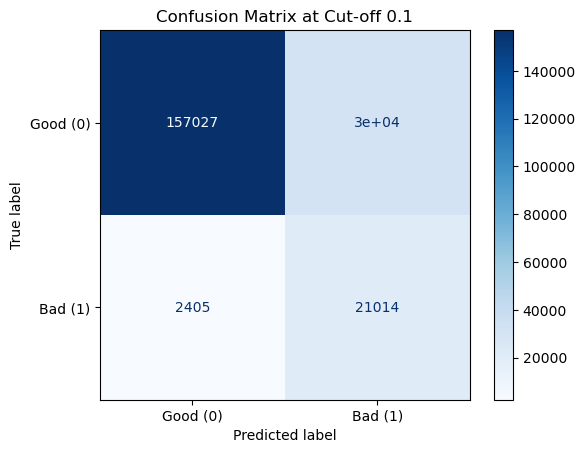

              precision    recall  f1-score   support

           0       0.98      0.84      0.91    187484
           1       0.41      0.90      0.56     23419

    accuracy                           0.84    210903
   macro avg       0.70      0.87      0.73    210903
weighted avg       0.92      0.84      0.87    210903


>>> THỐNG KÊ HẠNG KHÁCH HÀNG TRÊN TẬP OOT:
Rating
A                            10929
AA                           19064
AAA (Rất an toàn)           112836
B                            18678
BB                           15045
BBB                          16603
C (Rủi ro cao - Từ chối)     17748
Name: count, dtype: int64

>>> TỶ LỆ NỢ XẤU THỰC TẾ THEO HẠNG (Bad Rate by Grade):
Rating
A                           0.044469
AA                          0.018936
AAA (Rất an toàn)           0.002357
B                           0.336706
BB                          0.151811
BBB                         0.077817
C (Rủi ro cao - Từ chối)    0.700980
Name: Actual, dtype: float64

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ============================================================
# 7. NÂNG CAO: MONOTONICITY, CONFUSION MATRIX & RATING
# ============================================================
print("\n>>> [7/7] ADVANCED ANALYTICS & RATING...")

# 7.1. Kiểm tra tính đơn điệu (Monotonicity Check)
# EBM lưu các hàm đóng góp trong explain_global. 
# Bạn có thể vẽ lại để kiểm tra xem các biến ép đơn điệu có đúng đường thẳng/bậc thang không.
def check_monotonicity(ebm_model, feature_name):
    exp = ebm_model.explain_global(name=feature_name)
    plt.figure(figsize=(8, 5))
    plt.step(exp.data(0)['names'], exp.data(0)['scores'], where='post')
    plt.title(f"Monotonicity Check: {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Logit Contribution")
    plt.grid(True)
    plt.show()

# Chạy thử cho 2 biến tiêu biểu
# check_monotonicity(ebm_opt, 'MAX_DPD_12M_OBS') 
# check_monotonicity(ebm_opt, 'LTV')

# 7.2. Ma trận nhầm lẫn tại điểm cắt (Cut-off)
# Giả sử ngân hàng chọn Cut-off là 10% (PD > 0.1 là từ chối)
threshold = 0.1
y_prob_oot = ebm_opt.predict_proba(X_test)[:, 1]
y_pred_oot = (y_prob_oot >= threshold).astype(int)

print(f"\n>>> CONFUSION MATRIX (At Threshold {threshold}):")
cm = confusion_matrix(y_test, y_pred_oot)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good (0)', 'Bad (1)'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix at Cut-off {threshold}")
plt.show()

print(classification_report(y_test, y_pred_oot))

# 7.3. Phân hạng khách hàng (Credit Rating)
def assign_rating(pd):
    if pd <= 0.01: return 'AAA (Rất an toàn)'
    if pd <= 0.03: return 'AA'
    if pd <= 0.05: return 'A'
    if pd <= 0.10: return 'BBB'
    if pd <= 0.20: return 'BB'
    if pd <= 0.50: return 'B'
    return 'C (Rủi ro cao - Từ chối)'

# Tạo bảng kết quả cuối cùng cho tập Test
df_result = pd.DataFrame({
    'Actual': y_test.values,
    'PD': y_prob_oot
})

df_result['Rating'] = df_result['PD'].apply(assign_rating)

print("\n>>> THỐNG KÊ HẠNG KHÁCH HÀNG TRÊN TẬP OOT:")
rating_dist = df_result['Rating'].value_counts().sort_index()
print(rating_dist)

# Tính tỷ lệ nợ xấu thực tế trên mỗi hạng (Để kiểm tra tính phân tách)
bad_rate_by_rating = df_result.groupby('Rating')['Actual'].mean()
print("\n>>> TỶ LỆ NỢ XẤU THỰC TẾ THEO HẠNG (Bad Rate by Grade):")
print(bad_rate_by_rating)


>>> [8/7] CONVERTING PD TO CREDIT SCORE (300-850)...

>>> THỐNG KÊ ĐIỂM TÍN DỤNG TRÊN TẬP OOT:
count    210903.000000
mean        619.534563
std          89.389955
min         375.000000
25%         552.000000
50%         628.000000
75%         681.000000
max         753.000000
Name: Credit_Score, dtype: float64


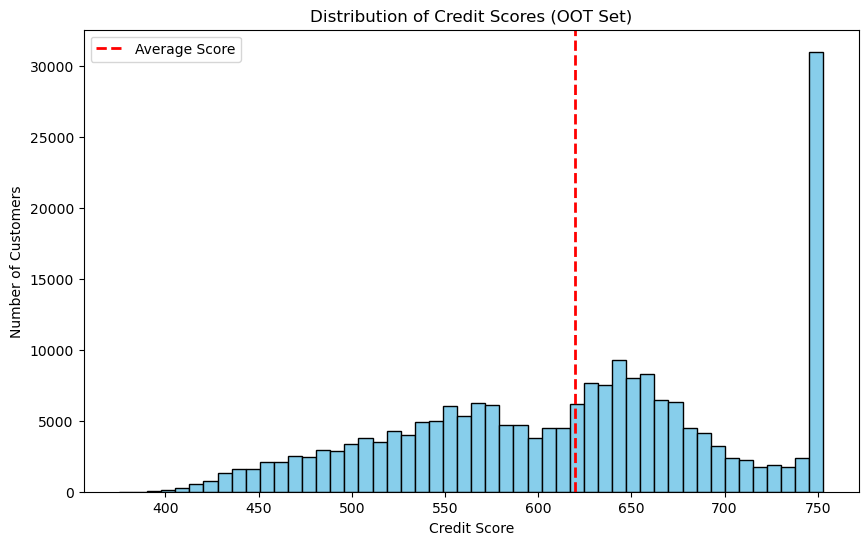


>>> ĐIỂM TRUNG BÌNH THEO HẠNG:
Rating
AAA (Rất an toàn)           689.156306
AA                          604.164708
A                           579.432336
BBB                         561.391977
BB                          539.468328
B                           508.320645
C (Rủi ro cao - Từ chối)    457.411539
Name: Credit_Score, dtype: float64


In [ ]:
# ============================================================
# 8. CREDIT SCORECARD CALCULATION (300 - 850)
# ============================================================
print("\n>>> [8/7] CONVERTING PD TO CREDIT SCORE (300-850)...")

def calculate_credit_score(pd, pdo=20, base_score=600, base_odds=50):
    """
    Chuyển đổi PD sang Credit Score dựa trên công thức chuẩn:
    Score = Offset + Factor * ln(odds)
    - pdo: Points to Double the Odds (thường là 20 hoặc 50)
    - base_score: Điểm cơ sở (ví dụ 600 điểm)
    - base_odds: Tỷ lệ odds tương ứng với điểm cơ sở (ví dụ 50:1)
    """
    # Tránh chia cho 0 hoặc log(0)
    pd = np.clip(pd, 0.0001, 0.9999)
    
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(base_odds)
    
    odds = (1 - pd) / pd
    score = offset + factor * np.log(odds)
    
    return np.round(score).astype(int)

# Áp dụng cho tập Test (OOT)
df_result['Credit_Score'] = calculate_credit_score(df_result['PD'])

# Giới hạn điểm trong khoảng 300 - 850 (như chuẩn FICO)
df_result['Credit_Score'] = df_result['Credit_Score'].clip(300, 850)

print("\n>>> THỐNG KÊ ĐIỂM TÍN DỤNG TRÊN TẬP OOT:")
print(df_result['Credit_Score'].describe())

# Vẽ biểu đồ phân phối điểm số
plt.figure(figsize=(10, 6))
plt.hist(df_result['Credit_Score'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(df_result['Credit_Score'].mean(), color='red', linestyle='dashed', linewidth=2, label='Average Score')
plt.title('Distribution of Credit Scores (OOT Set)')
plt.xlabel('Credit Score')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()

# Kiểm tra sự tương quan giữa Hạng và Điểm trung bình
print("\n>>> ĐIỂM TRUNG BÌNH THEO HẠNG:")
print(df_result.groupby('Rating')['Credit_Score'].mean().sort_values(ascending=False))